In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
#load Data
df=pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df=df.drop_duplicates()
#240 Duplicates dropped

In [4]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [5]:
df['quality'].value_counts().sort_index()

quality
3     10
4     53
5    577
6    535
7    167
8     17
Name: count, dtype: int64

In [6]:
#quality ratings not balanced
#combine 3,4 and 7,8
df['quality'] = df['quality'].replace({3: 4, 8:7})
df['quality'].value_counts().sort_index()

quality
4     63
5    577
6    535
7    184
Name: count, dtype: int64

In [35]:
correlations=df.corr()['quality']
correlations.sort_values(ascending=False)

quality                 1.00
alcohol                 0.48
sulphates               0.25
citric acid             0.23
fixed acidity           0.13
residual sugar          0.01
pH                     -0.05
free sulfur dioxide    -0.05
chlorides              -0.13
density                -0.18
total sulfur dioxide   -0.19
volatile acidity       -0.39
Name: quality, dtype: float64

In [7]:
# everything else except the target variable
X = df.drop("quality", axis=1)

# have only the target variable here (dependent variable)
y_temp = df['quality']

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
6,total sulfur dioxide,2514.75
5,free sulfur dioxide,161.69
1,volatile acidity,64.98
10,alcohol,41.65
2,citric acid,20.57
0,fixed acidity,8.99
3,residual sugar,5.48
9,sulphates,3.12
7,density,0.14
8,pH,0.02


In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [9]:
categories = list(np.unique(df['quality']))
print(categories)

[4, 5, 6, 7]


In [10]:
# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in classification depends on amount of output options in target variable
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories),activation="softmax")
    ]
)

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\janni\OneDrive\Fächer - Uni\5.Semester\VS_DeepL_AdDA\.venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 11)             │            44 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408 (1.59 KB)

 Trainable params: 386 (1.51 KB)

 Non-trainable params: 22 (88.00 B)

In [11]:
# adjust epochs as you see fit
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4142 - loss: 5.4171 - val_accuracy: 0.4510 - val_loss: 5.3235
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4306 - loss: 4.8321 - val_accuracy: 0.4510 - val_loss: 4.5073
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4385 - loss: 4.3366 - val_accuracy: 0.4510 - val_loss: 3.9915
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4469 - loss: 3.8644 - val_accuracy: 0.4559 - val_loss: 3.5580
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4420 - loss: 3.4610 - val_accuracy: 0.4853 - val_loss: 3.1706
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4214 - loss: 3.0783 - val_accuracy: 0.5049 - val_loss: 2.8220
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4424 - loss: 2.7269 - val_accuracy: 0.5294 - val_loss: 2.5022
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4695 - loss: 2.4017 - val_accuracy: 0.5343 - v

<Axes: >

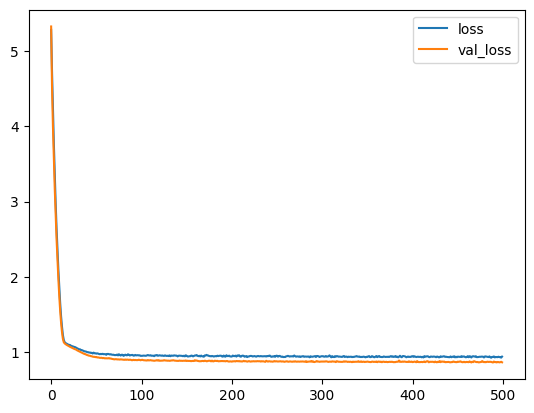

In [12]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

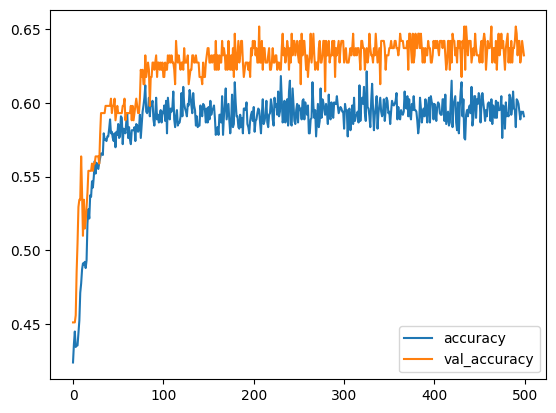

In [13]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [14]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[1.0159614086151123, 0.5147058963775635]

Train data evaluation:
[0.92765212059021, 0.5972660183906555]


In [15]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


<Axes: >

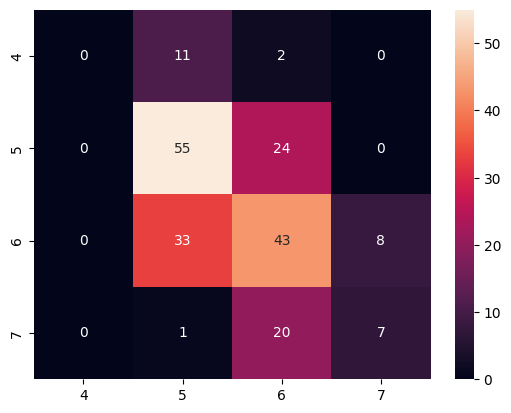

In [16]:
sns.heatmap(confusion_matrix(y_test, test_predictions),xticklabels=categories,yticklabels=categories, annot=True, fmt='g')

In [17]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.55      0.70      0.61        79
           2       0.48      0.51      0.50        84
           3       0.47      0.25      0.33        28

    accuracy                           0.51       204
   macro avg       0.37      0.36      0.36       204
weighted avg       0.48      0.51      0.49       204


Model overall accuracy: 51.47%


c:\Users\janni\OneDrive\Fächer - Uni\5.Semester\VS_DeepL_AdDA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\janni\OneDrive\Fächer - Uni\5.Semester\VS_DeepL_AdDA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\janni\OneDrive\Fächer - Uni\5.Semester\VS_DeepL_AdDA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

In [18]:
# The AUC score is a super sensitive metric
# you often get low scores, even 0.5

# in binary classification, AUC values are often interpreted as follows:
# A binary classifier is useful only when it achieves ROC-AUC score greater than 0.5 and as near to 1 as possible. 
# If a classifier yields a score less than 0.5, it simply means that the model is performing worse 
# than a random classifier, and therefore is useless.

# In multi category classification , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# get ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.7624202130145028

In [19]:
X.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')